# MNIST Neural Network



## Loading Data

Load MNIST dataset, and split the training images into 80% images to use for training and 20% images to use for validation.  
(N.B. The images are greyscale values ranging from 0.0 to 255.0, so will later need rescaling from 0.0 to 1.0)

In [31]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import pydot

In [32]:
def preprocess(image, label):
    # Cast to float32, normalise, and reshape to (28, 28, 1)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, (28, 28, 1))
    return image, label

batch_size = 32

# Load datasets
train_digits = tfds.load('mnist', split='train[:80%]', shuffle_files=True, as_supervised=True)
val_digits   = tfds.load('mnist', split='train[80%:]', as_supervised=True)
test_digits  = tfds.load('mnist', split='test', as_supervised=True)

# Apply preprocessing and batching
train_digits = train_digits.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_digits   = val_digits.map(preprocess).batch(batch_size)
test_digits  = test_digits.map(preprocess).batch(batch_size)

## Create CNN

Create Convolutional Neural Network model to train on MNIST data.

In [36]:
input_shape = (28, 28, 1)
input = tf.keras.Input(shape=(28, 28, 1))
regularizer = tf.keras.regularizers.L2(0.005)

# Expansion layer, to increase channels from 1 to 32
E1 = tf.keras.layers.Conv2D(32, (1, 1), strides=1, padding='same', activity_regularizer=regularizer)(input)
# SeparableConv2d layer, with 8 5x5 filters and stride 1, compress channels to 8
Z1 = tf.keras.layers.SeparableConv2D(8, (5, 5), strides=1, padding='same', activity_regularizer=regularizer)(E1)
# ReLU
A1 = tf.keras.layers.ReLU()(Z1)
# Expansion layer, to increase channels from 1 to 32
E2 = tf.keras.layers.Conv2D(32, (1, 1), strides=1, padding='same', activity_regularizer=regularizer)(A1)
# SeparableConv2d layer, with 8 5x5 filters and stride 1, compress channels to 8
Z2 = tf.keras.layers.SeparableConv2D(8, (5, 5), strides=1, padding='same', activity_regularizer=regularizer)(E2)
# Skip connection
A2 = tf.keras.layers.Add()([Z2, A1])
# ReLU
A2 = tf.keras.layers.ReLU()(A2)
# Max pooling
P1 = tf.keras.layers.MaxPool2D((2, 2), (2, 2))(A2)
# Expansion layer, to increase channels from 8 to 32
E3 = tf.keras.layers.Conv2D(32, (1, 1), strides=1, padding='same', activity_regularizer=regularizer)(P1)
# SeparableConv2d layer, with 8 5x5 filters and stride 1
Z3 = tf.keras.layers.SeparableConv2D(8, (5, 5), strides=1, padding='same', activity_regularizer=regularizer)(E3)
# ReLU
A3 = tf.keras.layers.ReLU()(Z3)
# Expansion layer, to increase channels from 8 to 32
E4 = tf.keras.layers.Conv2D(32, (1, 1), strides=1, padding='same', activity_regularizer=regularizer)(A3)
# SeparableConv2d layer, with 8 5x5 filters and stride 1
Z4 = tf.keras.layers.SeparableConv2D(8, (5, 5), strides=1, padding='same', activity_regularizer=regularizer)(E4)
# Skip connection
A4 = tf.keras.layers.Add()([Z4, P1])
# ReLU
A4 = tf.keras.layers.ReLU()(A4)
# Expansion layer, to increase channels from 8 to 32
E5 = tf.keras.layers.Conv2D(32, (1, 1), strides=1, padding='same', activity_regularizer=regularizer)(A4)
# SeparableConv2d layer, with 8 5x5 filters and stride 1
Z5 = tf.keras.layers.SeparableConv2D(8, (5, 5), strides=1, padding='same', activity_regularizer=regularizer)(E5)
# ReLU
A5 = tf.keras.layers.ReLU()(Z5)
# Expansion layer, to increase channels from 8 to 32
E6 = tf.keras.layers.Conv2D(32, (1, 1), strides=1, padding='same', activity_regularizer=regularizer)(A5)
# SeparableConv2d layer, with 8 5x5 filters and stride 1
Z6 = tf.keras.layers.SeparableConv2D(8, (5, 5), strides=1, padding='same', activity_regularizer=regularizer)(E6)
A6 = tf.keras.layers.Add()([Z6, A4])
A6 = tf.keras.layers.ReLU()(A6)
# Max pooling window 2x2, stride 2
P2 = tf.keras.layers.MaxPool2D((2, 2), (2, 2))(A6)
# Flatten
F = tf.keras.layers.Flatten()(P2)
FD = tf.keras.layers.Dropout(0.4)(F)
# dense layer, 80 nodes
D1 = tf.keras.layers.Dense(120, activation='relu', activity_regularizer=regularizer)(FD)
D1D = tf.keras.layers.Dropout(0.4)(D1)
# output layer
output = tf.keras.layers.Dense(10, activation='softmax')(D1D)

model = tf.keras.Model(inputs=input, outputs=output)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_50 (Conv2D)  │ (None, 28, 28,    │         64 │ input_layer_10[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_50 │ (None, 28, 28, 8) │      1,064 │ conv2d_50[0][0]   │
│ (SeparableConv2D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_50 (ReLU)     │ (None, 28, 28, 8) │          0 │ separable_conv2d… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_51 (Conv2D)  │ (None, 28, 28,    │        288 │ re_lu_50[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_51 │ (None, 28, 28, 8) │      1,064 │ conv2d_51[0][0]   │
│ (SeparableConv2D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_40 (Add)        │ (None, 28, 28, 8) │          0 │ separable_conv2d… │
│                     │                   │            │ re_lu_50[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_51 (ReLU)     │ (None, 28, 28, 8) │          0 │ add_40[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_20    │ (None, 14, 14, 8) │          0 │ re_lu_51[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_52 (Conv2D)  │ (None, 14, 14,    │        288 │ max_pooling2d_20… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_52 │ (None, 14, 14, 8) │      1,064 │ conv2d_52[0][0]   │
│ (SeparableConv2D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_52 (ReLU)     │ (None, 14, 14, 8) │          0 │ separable_conv2d… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_53 (Conv2D)  │ (None, 14, 14,    │        288 │ re_lu_52[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_53 │ (None, 14, 14, 8) │      1,064 │ conv2d_53[0][0]   │
│ (SeparableConv2D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_41 (Add)        │ (None, 14, 14, 8) │          0 │ separable_conv2d… │
│                     │                   │            │ max_pooling2d_20… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_53 (ReLU)     │ (None, 14, 14, 8) │          0 │ add_41[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_54 (Conv2D)  │ (None, 14, 14,    │        288 │ re_lu_53[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_54 │ (None, 14, 14, 8) │      1,064 │ conv2d_54[0][0]   │
│ (SeparableConv2D)   │                   │            │                 

 Total params: 56,258 (219.76 KB)

 Trainable params: 56,258 (219.76 KB)

 Non-trainable params: 0 (0.00 B)

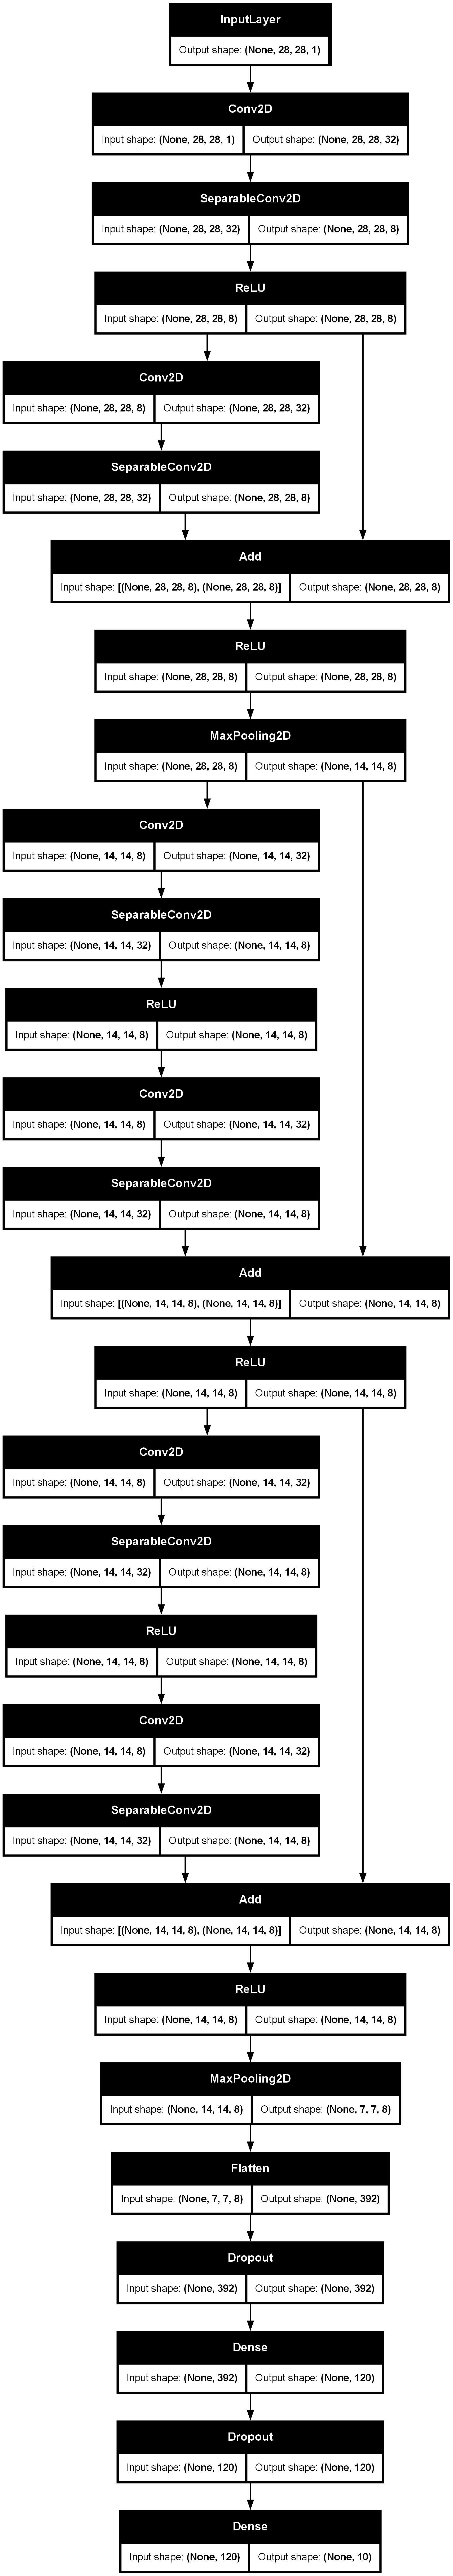

In [37]:
tf.keras.utils.plot_model(model, "model_plot.png", show_shapes=True)

## Train Model

Train the model on the training data, and use validation data to track accuracy and progress

In [38]:
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * 0.75

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
history = model.fit(train_digits, epochs=20, validation_data=val_digits, callbacks=[callback])

Epoch 1/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 157s 95ms/step - accuracy: 0.7903 - loss: 3.4010 - val_accuracy: 0.9398 - val_loss: 0.5686 - learning_rate: 0.0010
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 165s 110ms/step - accuracy: 0.9277 - loss: 0.5532 - val_accuracy: 0.9568 - val_loss: 0.3935 - learning_rate: 0.0010
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 142s 95ms/step - accuracy: 0.9446 - loss: 0.4198 - val_accuracy: 0.9667 - val_loss: 0.3143 - learning_rate: 0.0010
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 201s 94ms/step - accuracy: 0.9531 - loss: 0.3557 - val_accuracy: 0.9700 - val_loss: 0.2976 - learning_rate: 0.0010
Epoch 5/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 144s 96ms/step - accuracy: 0.9585 - loss: 0.3166 - val_accuracy: 0.9732 - val_loss: 0.2704 - learning_rate: 0.0010
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 142s 95ms/step - accuracy: 0.9636 - loss: 0.2721 - val_accuracy: 0.9747 - val_loss: 0.2128 - learning_rate: 7.5000e-04
Epoch 7/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 138s 92ms/s

### View Training History

C:\Users\User\AppData\Local\Temp\ipykernel_19616\1989446866.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'loss': 'Training', 'val_loss': 'Validation'}, inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_19616\1989446866.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acc.rename(columns={'accuracy': 'Training', 'val_accuracy': 'Validation'}, inplace=True)


<Axes: title={'center': 'Model Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>

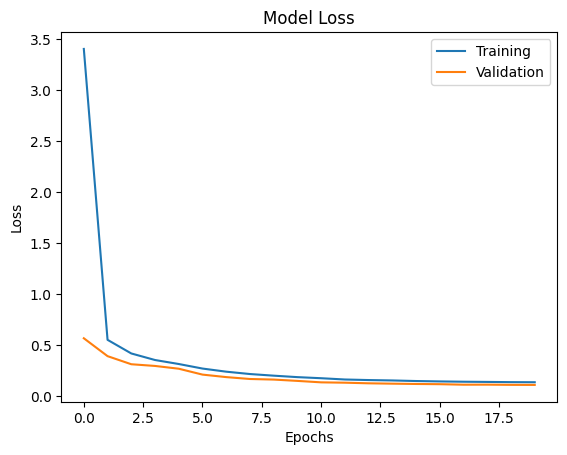

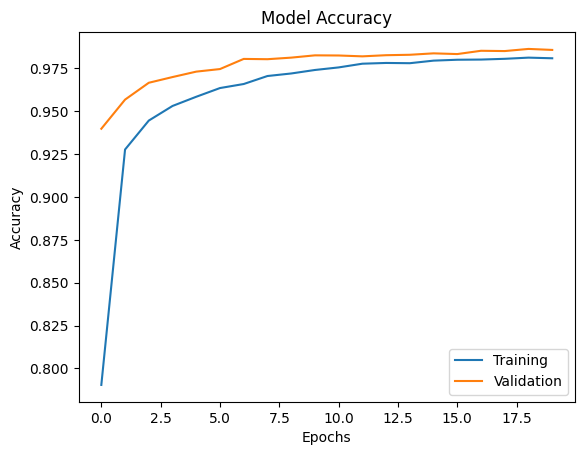

In [39]:
df_loss_acc = pd.DataFrame(history.history)
df_loss = df_loss_acc[['loss', 'val_loss']]
df_loss.rename(columns={'loss': 'Training', 'val_loss': 'Validation'}, inplace=True)

df_acc = df_loss_acc[['accuracy', 'val_accuracy']]
df_acc.rename(columns={'accuracy': 'Training', 'val_accuracy': 'Validation'}, inplace=True)

df_loss.plot(title='Model Loss', ylabel='Loss', xlabel='Epochs')
df_acc.plot(title='Model Accuracy', ylabel='Accuracy', xlabel='Epochs')

# Test Model

Test the model on test data.

In [40]:
model.evaluate(test_digits)

313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.9885 - loss: 0.1045


[0.10445082932710648, 0.9884999990463257]

### (Optional) Save Model

Save model weights, biases and structure so it can later be loaded and recreated.

In [41]:

model.save('mnist_res_net3_98.85.keras')